In [115]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib
import numpy as np
import re
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from Spelling_Correction_c  import Spelling_Correction_c
import seaborn as sns
from matplotlib import cm

import skseq
from skseq.sequences import sequence
from skseq.sequences.sequence import Sequence
from skseq.sequences.sequence_list import SequenceList
from skseq.sequences.label_dictionary import LabelDictionary
import skseq.sequences.structured_perceptron as spc
from skseq.sequences import extended_feature
import time

# Load and prepare the data
## Separation into train, validation and test

In [6]:
data_train = pd.read_csv("clean_train.csv")
data_test = pd.read_csv("clean_test.csv")

In [8]:
%%time 
X_train = []
Y_train = []

curr_sent = 'Sentence: 1'
list_sent = []
list_y = []
for i in range(data_train.shape[0]):
    #print("current {}/{}".format(i,data_train.shape[0]), end="\r")
    if data_train["Sentence #"][i] == curr_sent:
        list_sent.append(data_train['Word'][i])
        list_y.append(data_train['Tag'][i])
    else:
        curr_sent = data_train["Sentence #"][i]
        X_train.append(list_sent)
        Y_train.append(list_y)
        list_sent = [data_train['Word'][i]]
        list_y = [data_train['Tag'][i]]
        
X_test = []
Y_test = []

curr_sent = 'Sentence: 35970'
list_sent = []
list_y = []
for i in range(data_test.shape[0]):
    #print("current {}/{}".format(i,data_test.shape[0]), end="\r")
    if data_test["Sentence #"][i] == curr_sent:
        list_sent.append(data_test['Word'][i])
        list_y.append(data_test['Tag'][i])
    else:
        curr_sent = data_test["Sentence #"][i]
        X_test.append(list_sent)
        Y_test.append(list_y)
        list_sent = [data_test['Word'][i]]
        list_y = [data_test['Tag'][i]]


CPU times: user 42.5 s, sys: 144 ms, total: 42.7 s
Wall time: 42.7 s


In [9]:
def build_word_to_pos(X):

    word_to_pos = {}
    i = 0
    for s in X:
        for w in s:
            if w not in word_to_pos:
                word_to_pos[w] = i
                i +=1
                
    pos_to_word = {v: k for k, v in word_to_pos.items()}
    return word_to_pos, pos_to_word
            
def build_tag_to_pos(Y):
    tag_to_pos = {}
    i = 0
    for s in Y:
        for t in s:
            if t not in tag_to_pos:
                tag_to_pos[t] = i
                i +=1
    pos_to_tag = {v: k for k, v in tag_to_pos.items()}

    return tag_to_pos, pos_to_tag

In [10]:
X = [[w for w in s] for s in X_train]
Y = [[t for t in s] for s in Y_train]

X_test = [[w for w in s] for s in X_test]
Y_test = [[t for t in s] for s in Y_test]

In [11]:
from sklearn.model_selection import train_test_split
train_idx, val_idx, _, _ = train_test_split(np.arange(len(X)), np.arange(len(X)),
                                            test_size=0.2, random_state=42)

X_val = [X[i] for i in val_idx]
Y_val = [Y[i] for i in val_idx]

X_train = [X[i] for i in train_idx]
Y_train = [Y[i] for i in train_idx]

In [12]:
word_to_pos, pos_to_word = build_word_to_pos(X_train)
tag_to_pos, pos_to_tag  = build_tag_to_pos(Y_train)

## Prepare data for feature mapper and preceptron

In [15]:
def generate_sequence_list(X, y, word_to_pos, tag_to_pos):
    # Generate x and y dicts
    x_dict = LabelDictionary(word_to_pos.keys())
    y_dict = LabelDictionary(tag_to_pos.keys())
    # Generate SequenceList
    seq_list = SequenceList(x_dict, y_dict)
    # Add words/tags to sequencelist
    for i in range(len(X)):
        seq_list.add_sequence(X[i], y[i], x_dict, y_dict)
    return seq_list

train_seq = generate_sequence_list(X_train, Y_train, word_to_pos, tag_to_pos)

## Spelling mistakes

In [16]:
words = list(word_to_pos.keys())
spelling = Spelling_Correction_c(words, tol = 1)

## Code for evaluation

In [22]:
def accuracy_corpus(sequences, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    total = 0.0
    correct = 0.0
    for i, sequence in enumerate(sequences):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if sequence.y[j] == y_hat:
                correct += 1
            total += 1
    return correct / total


def accuracy_predictions(y_seq, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    total = 0.0
    correct = 0.0
    for i, ys in enumerate(y_seq):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if tag_to_pos[ys[j]] == y_hat:
                correct += 1
            total += 1
    return correct / total

In [23]:
tags = list(tag_to_pos.keys())

def confusion_matrix_corpus(sequences, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    confusion = np.zeros((len(tags), len(tags)))
    for i, sequence in enumerate(sequences):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if sequence.y[j] == y_hat:
                confusion[y_hat, y_hat] +=1
            else:
                confusion[sequence.y[j], y_hat] +=1
            
    return confusion


def confusion_matrix_predictions(y_seq, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    total = 0.0
    confusion = np.zeros((len(tags), len(tags)))
    for i, ys in enumerate(y_seq):
        pred = sequences_predictions[i]
        for j, y_hat in enumerate(pred.y):
            if tag_to_pos[ys[j]] == y_hat:
                confusion[y_hat, y_hat] +=1
            else:
                confusion[tag_to_pos[ys[j]], y_hat] +=1      
    return confusion

In [47]:
def sentences_no_errors_corpus(sequences, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    num_correct = 0
    for i, sequence in enumerate(sequences):
        pred = sequences_predictions[i]
        n = len(pred.y)
        count = 0
        for j, y_hat in enumerate(pred.y):
            if sequence.y[j] == y_hat:
                count +=1
        if count == n:
            num_correct+=1
            
    return num_correct


def sentences_no_errors_predictions(y_seq, sequences_predictions):
    """Evaluate classification accuracy at corpus level, comparing with
    gold standard."""
    num_correct = 0
    for i, ys in enumerate(y_seq):
        pred = sequences_predictions[i]
        n = len(pred.y)
        count = 0
        for j, y_hat in enumerate(pred.y):
            if tag_to_pos[ys[j]] == y_hat:
                count+=1
        if count==n:
            num_correct+=1
        
    return num_correct

In [31]:
sentences_test = [
    "The programmers from Barcelona might write a sentence without a spell checker.",
    "The programmers from Barchelona might write a sentence without a spell checker.",
    "Jack London went to Parris.",
    "Jack London went to Paris.",
    "We never though Microsoft would become such a big company.",
    "We never though Microsof would become such a big company.",
    "The president of U.S.A. though they would win the war",
    "The president of the United States of America though they could win the war",
    "The king of Saudi Arabia wanted total control.",
    "Robin does not want to go to Saudi Arabia.",
    "Apple is a great company.",
    "I really love apples and oranges."
]

sentences_seq_test = []
for p in sentences_test:
    sentences_seq_test.append(skseq.sequences.sequence.Sequence(x=p.split(), y=[int(0) for w in p.split()]))

# Code for obtaining results

In [53]:
def get_prediction_results():
    pred_val = []
    for i in range(len(X_val)):
        p = X_val[i]
        new_seq = skseq.sequences.sequence.Sequence(x=p, y=[int(0) for w in p])
        res = sp.viterbi_decode(new_seq)[0]
        pred_val.append(res)

    pred_test = []
    for i in range(len(X_test)):
        p = X_test[i]
        new_seq = skseq.sequences.sequence.Sequence(x=p, y=[int(0) for w in p])
        res = sp.viterbi_decode(new_seq)[0]
        pred_test.append(res)

    pred_train = sp.viterbi_decode_corpus(train_seq)
    
    return pred_val, pred_test, pred_train
    
def get_prediction_acc(pred_val, pred_train, pred_test):
    eval_train = accuracy_corpus(train_seq.seq_list, pred_train)
    eval_val = accuracy_predictions(Y_val, pred_val)
    eval_test = accuracy_predictions(Y_test, pred_test)
    return eval_train, eval_val, eval_test

def show_confussion_images():
    eval_train = confusion_matrix_corpus(train_seq.seq_list, pred_train)
    eval_val = confusion_matrix_predictions(Y_val, pred_val)
    eval_test = confusion_matrix_predictions(Y_test, pred_test)

    eval_train = pd.DataFrame(eval_train, columns =tags, index = tags)
    eval_val = pd.DataFrame(eval_val, columns =tags, index = tags)
    eval_test = pd.DataFrame(eval_test, columns =tags, index = tags)
    
    sns.heatmap(np.log(eval_train+1))
    plt.show()

    sns.heatmap(np.log(eval_val+1))
    plt.show()

    sns.heatmap(np.log(eval_test+1))
    plt.show()
    
    return eval_train, eval_val, eval_test

# Training with different features

## Feature: closest word

In [17]:
feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(train_seq, spelling, closestWord = True,
                                                                  suffix = False, capitalized = False,
                                                                  uppercase = False, Dot = False,
                                                                  Hyphen = False, Numeric = False,
                                                                  LettersNumbers = False, DaysWeek = False)
feature_mapper.build_features() #get the features
#Show the tags
set([x.split(":")[0] for x in feature_mapper.feature_dict.keys()])

{'closestWord', 'final_prev_tag', 'id', 'init_tag', 'prev_tag'}

In [19]:
%%time
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, feature_mapper)
num_epochs = 15
sp.fit(feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.882237
Epoch: 1 Accuracy: 0.924819
Epoch: 2 Accuracy: 0.935656
Epoch: 3 Accuracy: 0.942448
Epoch: 4 Accuracy: 0.946860
Epoch: 5 Accuracy: 0.949389
Epoch: 6 Accuracy: 0.952488
Epoch: 7 Accuracy: 0.954146
Epoch: 8 Accuracy: 0.955534
Epoch: 9 Accuracy: 0.956071
Epoch: 10 Accuracy: 0.957412
Epoch: 11 Accuracy: 0.958421
Epoch: 12 Accuracy: 0.959256
Epoch: 13 Accuracy: 0.960157
Epoch: 14 Accuracy: 0.960857
CPU times: user 1h 46s, sys: 2.69 s, total: 1h 49s
Wall time: 1h 46s


In [55]:
pred_val, pred_test, pred_train = get_prediction_results()

In [56]:
eval_train, eval_val, eval_test = get_prediction_acc(pred_val, pred_train, pred_test)
print("SP -  Accuracy Train: %.4f Validation: %.4f Test: %.4f"%(eval_train, eval_val, eval_test))

SP -  Accuracy Train: 0.9623 Validation: 0.9476 Test: 0.9475


In [32]:
for new_seq in sentences_seq_test:
    print(sp.viterbi_decode(new_seq)[0].to_words(train_seq,
                                       only_tag_translation=True))

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/B-per checker./I-per 
The/O programmers/O from/O Barchelona/O might/O write/O a/O sentence/O without/O a/O spell/B-per checker./I-per 
Jack/B-per London/B-geo went/O to/O Parris./O 
Jack/B-per London/B-geo went/O to/O Paris./O 
We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O 
We/O never/O though/O Microsof/O would/O become/O such/O a/O big/O company./O 
The/O president/O of/O U.S.A./O though/O they/O would/O win/O the/O war/O 
The/O president/O of/O the/O United/B-org States/I-org of/I-org America/I-org though/O they/O could/O win/O the/O war/O 
The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O 
Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-org Arabia./I-org 
Apple/O is/O a/O great/O company./O 
I/O really/O love/O apples/O and/O oranges./O 


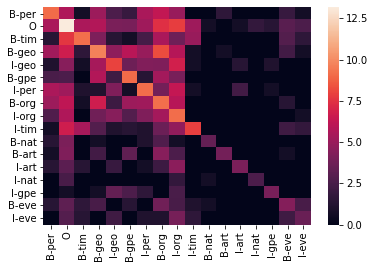

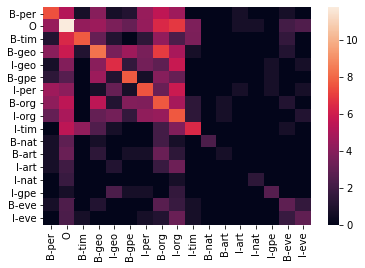

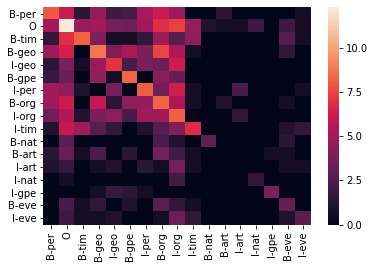

In [54]:
conf_train, conf_val, conf_test= show_confussion_images()

In [48]:
# Evaluate and print number of sentences without error
eval_train = sentences_no_errors_corpus(train_seq.seq_list, pred_train)
eval_val = sentences_no_errors_predictions(Y_val, pred_val)
eval_test = sentences_no_errors_predictions(Y_test, pred_test)

print("SP - Number of sentences Train: %.0f Validation: %.0f Test: %.0f"%(len(pred_train), len(Y_val), len(Y_test)))
print("SP - Number of sentences wihtout error Train: %.0f Validation: %.0f Test: %.0f"%(eval_train, eval_val, eval_test))

SP - Number of sentences Train: 28773 Validation: 7194 Test: 11989
SP - Number of sentences wihtout error Train: 17033 Validation: 3663 Test: 5995


In [29]:
sp.save_model("comparison_extended_features_1")

## Feature: closest word + suffixes

In [50]:
feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(train_seq, spelling, closestWord = True,
                                                                  suffix = True, capitalized = False,
                                                                  uppercase = False, Dot = False,
                                                                  Hyphen = False, Numeric = False,
                                                                  LettersNumbers = False, DaysWeek = False)
feature_mapper.build_features() #get the features
#Show the tags
set([x.split(":")[0] for x in feature_mapper.feature_dict.keys()])

{'closestWord', 'final_prev_tag', 'id', 'init_tag', 'prev_tag', 'suffix'}

In [57]:
%%time
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, feature_mapper)
num_epochs = 15
sp.fit(feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.887219
Epoch: 1 Accuracy: 0.925168
Epoch: 2 Accuracy: 0.936232
Epoch: 3 Accuracy: 0.942011
Epoch: 4 Accuracy: 0.946561
Epoch: 5 Accuracy: 0.949671
Epoch: 6 Accuracy: 0.951715
Epoch: 7 Accuracy: 0.953362
Epoch: 8 Accuracy: 0.955339
Epoch: 9 Accuracy: 0.956458
Epoch: 10 Accuracy: 0.957219
Epoch: 11 Accuracy: 0.958245
Epoch: 12 Accuracy: 0.958389
Epoch: 13 Accuracy: 0.959243
Epoch: 14 Accuracy: 0.960461
CPU times: user 1h 1min 44s, sys: 2.46 s, total: 1h 1min 47s
Wall time: 1h 1min 42s


In [59]:
pred_val, pred_test, pred_train = get_prediction_results()
eval_train, eval_val, eval_test = get_prediction_acc(pred_val, pred_train, pred_test)
print("SP -  Accuracy Train: %.4f Validation: %.4f Test: %.4f"%(eval_train, eval_val, eval_test))

SP -  Accuracy Train: 0.9645 Validation: 0.9515 Test: 0.9520


In [60]:
for new_seq in sentences_seq_test:
    print(sp.viterbi_decode(new_seq)[0].to_words(train_seq,
                                       only_tag_translation=True))

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
The/O programmers/O from/O Barchelona/O might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
Jack/B-per London/B-geo went/O to/O Parris./O 
Jack/B-per London/B-geo went/O to/O Paris./O 
We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O 
We/O never/O though/O Microsof/O would/O become/O such/O a/O big/O company./O 
The/O president/O of/O U.S.A./O though/O they/O would/O win/O the/O war/O 
The/O president/O of/O the/O United/B-org States/I-org of/I-org America/I-org though/O they/O could/O win/O the/O war/O 
The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O 
Robin/O does/O not/O want/O to/O go/O to/O Saudi/O Arabia./O 
Apple/O is/O a/O great/O company./O 
I/O really/O love/O apples/O and/O oranges./O 


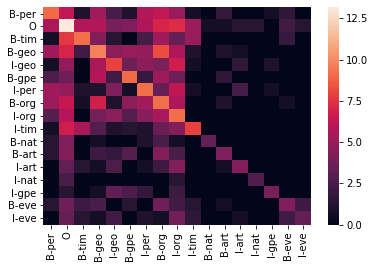

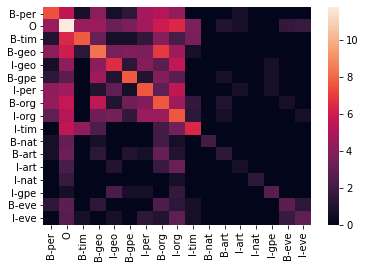

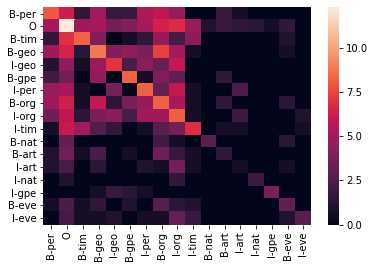

In [61]:
conf_train, conf_val, conf_test= show_confussion_images()

In [62]:
# Evaluate and print number of sentences without error
eval_train = sentences_no_errors_corpus(train_seq.seq_list, pred_train)
eval_val = sentences_no_errors_predictions(Y_val, pred_val)
eval_test = sentences_no_errors_predictions(Y_test, pred_test)

print("SP - Number of sentences Train: %.0f Validation: %.0f Test: %.0f"%(len(pred_train), len(Y_val), len(Y_test)))
print("SP - Number of sentences wihtout error Train: %.0f Validation: %.0f Test: %.0f"%(eval_train, eval_val, eval_test))

SP - Number of sentences Train: 28773 Validation: 7194 Test: 11989
SP - Number of sentences wihtout error Train: 17227 Validation: 3790 Test: 6242


In [63]:
sp.save_model("comparison_extended_features_2")

## Closest word + suffixes + capitalized

In [64]:
feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(train_seq, spelling, closestWord = True,
                                                                  suffix = True, capitalized = True,
                                                                  uppercase = False, Dot = False,
                                                                  Hyphen = False, Numeric = False,
                                                                  LettersNumbers = False, DaysWeek = False)
feature_mapper.build_features() #get the features
#Show the tags
set([x.split(":")[0] for x in feature_mapper.feature_dict.keys()])

{'capitalized',
 'closestWord',
 'final_prev_tag',
 'id',
 'init_tag',
 'prev_tag',
 'suffix'}

In [65]:
%%time
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, feature_mapper)
num_epochs = 15
sp.fit(feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.922210
Epoch: 1 Accuracy: 0.940324
Epoch: 2 Accuracy: 0.945706
Epoch: 3 Accuracy: 0.948811
Epoch: 4 Accuracy: 0.951070
Epoch: 5 Accuracy: 0.953092
Epoch: 6 Accuracy: 0.954714
Epoch: 7 Accuracy: 0.955855
Epoch: 8 Accuracy: 0.956731
Epoch: 9 Accuracy: 0.957720
Epoch: 10 Accuracy: 0.958944
Epoch: 11 Accuracy: 0.959294
Epoch: 12 Accuracy: 0.960000
Epoch: 13 Accuracy: 0.960455
Epoch: 14 Accuracy: 0.960885
CPU times: user 1h 1min 34s, sys: 1.94 s, total: 1h 1min 36s
Wall time: 1h 1min 33s


In [66]:
pred_val, pred_test, pred_train = get_prediction_results()
eval_train, eval_val, eval_test = get_prediction_acc(pred_val, pred_train, pred_test)
print("SP -  Accuracy Train: %.4f Validation: %.4f Test: %.4f"%(eval_train, eval_val, eval_test))

SP -  Accuracy Train: 0.9571 Validation: 0.9475 Test: 0.9485


In [67]:
for new_seq in sentences_seq_test:
    print(sp.viterbi_decode(new_seq)[0].to_words(train_seq,
                                       only_tag_translation=True))

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
The/O programmers/O from/O Barchelona/B-org might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
Jack/B-per London/B-geo went/O to/O Parris./B-eve 
Jack/B-per London/B-geo went/O to/O Paris./B-eve 
We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O 
We/O never/O though/O Microsof/B-org would/O become/O such/O a/O big/O company./O 
The/O president/O of/O U.S.A./B-org though/O they/O would/O win/O the/O war/O 
The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo though/O they/O could/O win/O the/O war/O 
The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O 
Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-org Arabia./I-org 
Apple/O is/O a/O great/O company./O 
I/O really/O love/O apples/O and/O oranges./O 


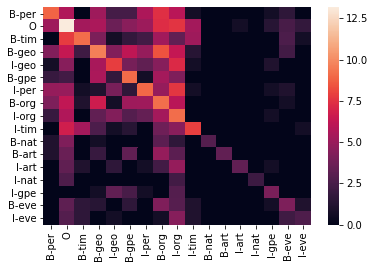

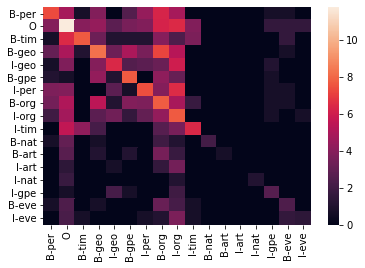

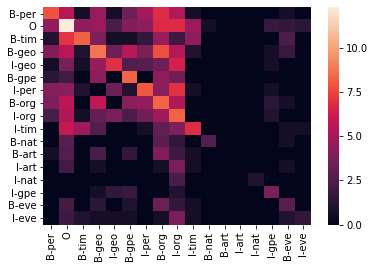

In [68]:
conf_train, conf_val, conf_test= show_confussion_images()

In [69]:
# Evaluate and print number of sentences without error
eval_train = sentences_no_errors_corpus(train_seq.seq_list, pred_train)
eval_val = sentences_no_errors_predictions(Y_val, pred_val)
eval_test = sentences_no_errors_predictions(Y_test, pred_test)

print("SP - Number of sentences Train: %.0f Validation: %.0f Test: %.0f"%(len(pred_train), len(Y_val), len(Y_test)))
print("SP - Number of sentences wihtout error Train: %.0f Validation: %.0f Test: %.0f"%(eval_train, eval_val, eval_test))

SP - Number of sentences Train: 28773 Validation: 7194 Test: 11989
SP - Number of sentences wihtout error Train: 16450 Validation: 3673 Test: 6079


In [70]:
sp.save_model("comparison_extended_features_3")

## Closest word + suffix + capitalized + uppercase

In [71]:
feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(train_seq, spelling, closestWord = True,
                                                                  suffix = True, capitalized = True,
                                                                  uppercase = True, Dot = False,
                                                                  Hyphen = False, Numeric = False,
                                                                  LettersNumbers = False, DaysWeek = False)
feature_mapper.build_features() #get the features
#Show the tags
set([x.split(":")[0] for x in feature_mapper.feature_dict.keys()])

{'capitalized',
 'closestWord',
 'final_prev_tag',
 'id',
 'init_tag',
 'prev_tag',
 'suffix',
 'uppercase'}

In [72]:
%%time
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, feature_mapper)
num_epochs = 15
sp.fit(feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.923056
Epoch: 1 Accuracy: 0.940415
Epoch: 2 Accuracy: 0.945558
Epoch: 3 Accuracy: 0.948881
Epoch: 4 Accuracy: 0.951154
Epoch: 5 Accuracy: 0.953087
Epoch: 6 Accuracy: 0.954622
Epoch: 7 Accuracy: 0.956051
Epoch: 8 Accuracy: 0.956798
Epoch: 9 Accuracy: 0.957437
Epoch: 10 Accuracy: 0.958186
Epoch: 11 Accuracy: 0.959238
Epoch: 12 Accuracy: 0.959779
Epoch: 13 Accuracy: 0.960699
Epoch: 14 Accuracy: 0.960692
CPU times: user 1h 2min 55s, sys: 1.74 s, total: 1h 2min 57s
Wall time: 1h 2min 54s


In [73]:
pred_val, pred_test, pred_train = get_prediction_results()
eval_train, eval_val, eval_test = get_prediction_acc(pred_val, pred_train, pred_test)
print("SP -  Accuracy Train: %.4f Validation: %.4f Test: %.4f"%(eval_train, eval_val, eval_test))

SP -  Accuracy Train: 0.9580 Validation: 0.9482 Test: 0.9488


In [74]:
for new_seq in sentences_seq_test:
    print(sp.viterbi_decode(new_seq)[0].to_words(train_seq,
                                       only_tag_translation=True))

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
The/O programmers/O from/O Barchelona/B-org might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
Jack/B-per London/B-geo went/O to/O Parris./B-eve 
Jack/B-per London/B-geo went/O to/O Paris./B-eve 
We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O 
We/O never/O though/O Microsof/B-org would/O become/O such/O a/O big/O company./O 
The/O president/O of/O U.S.A./B-org though/O they/O would/O win/O the/O war/O 
The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo though/O they/O could/O win/O the/O war/O 
The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O 
Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-org Arabia./I-org 
Apple/O is/O a/O great/O company./O 
I/O really/O love/O apples/O and/O oranges./O 


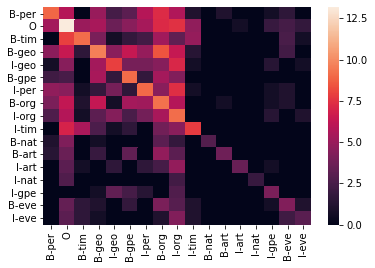

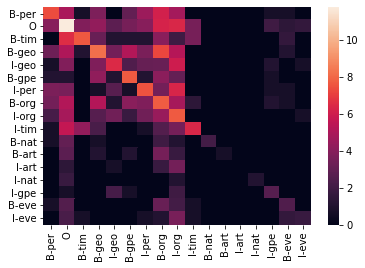

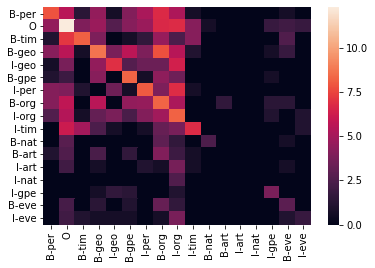

In [75]:
conf_train, conf_val, conf_test= show_confussion_images()

In [76]:
# Evaluate and print number of sentences without error
eval_train = sentences_no_errors_corpus(train_seq.seq_list, pred_train)
eval_val = sentences_no_errors_predictions(Y_val, pred_val)
eval_test = sentences_no_errors_predictions(Y_test, pred_test)

print("SP - Number of sentences Train: %.0f Validation: %.0f Test: %.0f"%(len(pred_train), len(Y_val), len(Y_test)))
print("SP - Number of sentences wihtout error Train: %.0f Validation: %.0f Test: %.0f"%(eval_train, eval_val, eval_test))

SP - Number of sentences Train: 28773 Validation: 7194 Test: 11989
SP - Number of sentences wihtout error Train: 16448 Validation: 3663 Test: 6060


In [77]:
sp.save_model("comparison_extended_features_4")

## Closest word + suffix + capitalized + uppercase + dot

In [78]:
feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(train_seq, spelling, closestWord = True,
                                                                  suffix = True, capitalized = True,
                                                                  uppercase = True, Dot = True,
                                                                  Hyphen = False, Numeric = False,
                                                                  LettersNumbers = False, DaysWeek = False)
feature_mapper.build_features() #get the features
#Show the tags
set([x.split(":")[0] for x in feature_mapper.feature_dict.keys()])

{'Dot',
 'capitalized',
 'closestWord',
 'final_prev_tag',
 'id',
 'init_tag',
 'prev_tag',
 'suffix',
 'uppercase'}

In [79]:
%%time
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, feature_mapper)
num_epochs = 15
sp.fit(feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.922795
Epoch: 1 Accuracy: 0.940110
Epoch: 2 Accuracy: 0.945760
Epoch: 3 Accuracy: 0.948957
Epoch: 4 Accuracy: 0.951172
Epoch: 5 Accuracy: 0.953146
Epoch: 6 Accuracy: 0.954943
Epoch: 7 Accuracy: 0.955676
Epoch: 8 Accuracy: 0.956994
Epoch: 9 Accuracy: 0.957870
Epoch: 10 Accuracy: 0.958547
Epoch: 11 Accuracy: 0.959197
Epoch: 12 Accuracy: 0.959359
Epoch: 13 Accuracy: 0.960617
Epoch: 14 Accuracy: 0.960887
CPU times: user 1h 1min 44s, sys: 1.57 s, total: 1h 1min 46s
Wall time: 1h 1min 43s


In [80]:
pred_val, pred_test, pred_train = get_prediction_results()
eval_train, eval_val, eval_test = get_prediction_acc(pred_val, pred_train, pred_test)
print("SP -  Accuracy Train: %.4f Validation: %.4f Test: %.4f"%(eval_train, eval_val, eval_test))

SP -  Accuracy Train: 0.9560 Validation: 0.9467 Test: 0.9480


In [81]:
for new_seq in sentences_seq_test:
    print(sp.viterbi_decode(new_seq)[0].to_words(train_seq,
                                       only_tag_translation=True))

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
The/O programmers/O from/O Barchelona/B-org might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
Jack/B-per London/B-geo went/O to/O Parris./B-org 
Jack/B-per London/B-geo went/O to/O Paris./B-org 
We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O 
We/O never/O though/O Microsof/B-org would/O become/O such/O a/O big/O company./O 
The/O president/O of/O U.S.A./B-org though/O they/O would/O win/O the/O war/O 
The/O president/O of/O the/O United/B-org States/I-org of/I-org America/I-org though/O they/O could/O win/O the/O war/O 
The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O 
Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-per Arabia./I-per 
Apple/B-org is/O a/O great/O company./O 
I/O really/O love/O apples/O and/O oranges./O 


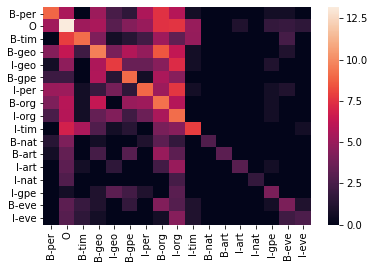

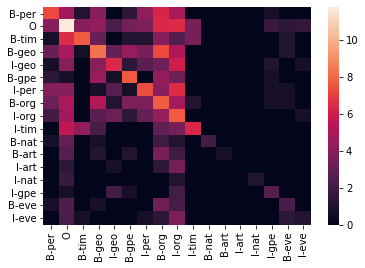

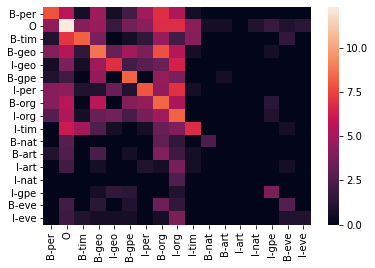

In [82]:
conf_train, conf_val, conf_test= show_confussion_images()

In [83]:
# Evaluate and print number of sentences without error
eval_train = sentences_no_errors_corpus(train_seq.seq_list, pred_train)
eval_val = sentences_no_errors_predictions(Y_val, pred_val)
eval_test = sentences_no_errors_predictions(Y_test, pred_test)

print("SP - Number of sentences Train: %.0f Validation: %.0f Test: %.0f"%(len(pred_train), len(Y_val), len(Y_test)))
print("SP - Number of sentences wihtout error Train: %.0f Validation: %.0f Test: %.0f"%(eval_train, eval_val, eval_test))

SP - Number of sentences Train: 28773 Validation: 7194 Test: 11989
SP - Number of sentences wihtout error Train: 16214 Validation: 3628 Test: 6054


In [84]:
sp.save_model("comparison_extended_features_5")

## Closest word + suffix + capitalized + uppercase + dot + hyphen

In [85]:
feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(train_seq, spelling, closestWord = True,
                                                                  suffix = True, capitalized = True,
                                                                  uppercase = True, Dot = True,
                                                                  Hyphen = True, Numeric = False,
                                                                  LettersNumbers = False, DaysWeek = False)
feature_mapper.build_features() #get the features
#Show the tags
set([x.split(":")[0] for x in feature_mapper.feature_dict.keys()])

{'Dot',
 'Hyphen',
 'capitalized',
 'closestWord',
 'final_prev_tag',
 'id',
 'init_tag',
 'prev_tag',
 'suffix',
 'uppercase'}

In [86]:
%%time
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, feature_mapper)
num_epochs = 15
sp.fit(feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.923299
Epoch: 1 Accuracy: 0.940679
Epoch: 2 Accuracy: 0.945905
Epoch: 3 Accuracy: 0.948906
Epoch: 4 Accuracy: 0.950959
Epoch: 5 Accuracy: 0.953229
Epoch: 6 Accuracy: 0.954615
Epoch: 7 Accuracy: 0.955911
Epoch: 8 Accuracy: 0.956676
Epoch: 9 Accuracy: 0.957876
Epoch: 10 Accuracy: 0.958672
Epoch: 11 Accuracy: 0.959118
Epoch: 12 Accuracy: 0.959938
Epoch: 13 Accuracy: 0.960172
Epoch: 14 Accuracy: 0.960728
CPU times: user 1h 2min 4s, sys: 1.62 s, total: 1h 2min 5s
Wall time: 1h 2min 2s


In [87]:
pred_val, pred_test, pred_train = get_prediction_results()
eval_train, eval_val, eval_test = get_prediction_acc(pred_val, pred_train, pred_test)
print("SP -  Accuracy Train: %.4f Validation: %.4f Test: %.4f"%(eval_train, eval_val, eval_test))

SP -  Accuracy Train: 0.9592 Validation: 0.9494 Test: 0.9501


In [88]:
for new_seq in sentences_seq_test:
    print(sp.viterbi_decode(new_seq)[0].to_words(train_seq,
                                       only_tag_translation=True))

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
The/O programmers/O from/O Barchelona/B-org might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
Jack/B-per London/B-geo went/O to/O Parris./B-eve 
Jack/B-per London/B-geo went/O to/O Paris./B-eve 
We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O 
We/O never/O though/O Microsof/B-org would/O become/O such/O a/O big/O company./O 
The/O president/O of/O U.S.A./B-org though/O they/O would/O win/O the/O war/O 
The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo though/O they/O could/O win/O the/O war/O 
The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O 
Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-per Arabia./I-per 
Apple/O is/O a/O great/O company./O 
I/O really/O love/O apples/O and/O oranges./O 


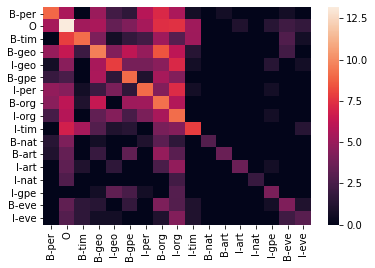

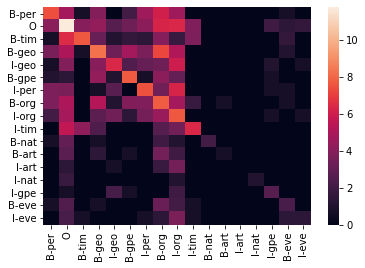

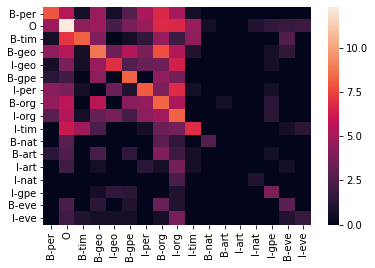

In [89]:
conf_train, conf_val, conf_test= show_confussion_images()

In [90]:
# Evaluate and print number of sentences without error
eval_train = sentences_no_errors_corpus(train_seq.seq_list, pred_train)
eval_val = sentences_no_errors_predictions(Y_val, pred_val)
eval_test = sentences_no_errors_predictions(Y_test, pred_test)

print("SP - Number of sentences Train: %.0f Validation: %.0f Test: %.0f"%(len(pred_train), len(Y_val), len(Y_test)))
print("SP - Number of sentences wihtout error Train: %.0f Validation: %.0f Test: %.0f"%(eval_train, eval_val, eval_test))

SP - Number of sentences Train: 28773 Validation: 7194 Test: 11989
SP - Number of sentences wihtout error Train: 16615 Validation: 3705 Test: 6172


In [91]:
sp.save_model("comparison_extended_features_6")

## Closest word + suffix + capitalized + uppercase + dot + hyphen + numeric

In [92]:
feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(train_seq, spelling, closestWord = True,
                                                                  suffix = True, capitalized = True,
                                                                  uppercase = True, Dot = True,
                                                                  Hyphen = True, Numeric = True,
                                                                  LettersNumbers = False, DaysWeek = False)
feature_mapper.build_features() #get the features
#Show the tags
set([x.split(":")[0] for x in feature_mapper.feature_dict.keys()])

{'Dot',
 'Hyphen',
 'Numeric',
 'capitalized',
 'closestWord',
 'final_prev_tag',
 'id',
 'init_tag',
 'prev_tag',
 'suffix',
 'uppercase'}

In [93]:
%%time
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, feature_mapper)
num_epochs = 15
sp.fit(feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.927138
Epoch: 1 Accuracy: 0.942781
Epoch: 2 Accuracy: 0.947334
Epoch: 3 Accuracy: 0.950192
Epoch: 4 Accuracy: 0.952339
Epoch: 5 Accuracy: 0.954210
Epoch: 6 Accuracy: 0.955321
Epoch: 7 Accuracy: 0.956399
Epoch: 8 Accuracy: 0.957548
Epoch: 9 Accuracy: 0.958288
Epoch: 10 Accuracy: 0.958884
Epoch: 11 Accuracy: 0.959482
Epoch: 12 Accuracy: 0.960149
Epoch: 13 Accuracy: 0.960862
Epoch: 14 Accuracy: 0.961180
CPU times: user 1h 2min, sys: 1.53 s, total: 1h 2min 2s
Wall time: 1h 1min 59s


In [94]:
pred_val, pred_test, pred_train = get_prediction_results()
eval_train, eval_val, eval_test = get_prediction_acc(pred_val, pred_train, pred_test)
print("SP -  Accuracy Train: %.4f Validation: %.4f Test: %.4f"%(eval_train, eval_val, eval_test))

SP -  Accuracy Train: 0.9555 Validation: 0.9464 Test: 0.9472


In [95]:
for new_seq in sentences_seq_test:
    print(sp.viterbi_decode(new_seq)[0].to_words(train_seq,
                                       only_tag_translation=True))

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
The/O programmers/O from/O Barchelona/B-org might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
Jack/B-per London/B-geo went/O to/O Parris./B-eve 
Jack/B-per London/B-geo went/O to/O Paris./B-eve 
We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O 
We/O never/O though/O Microsof/B-org would/O become/O such/O a/O big/O company./O 
The/O president/O of/O U.S.A./B-org though/O they/O would/O win/O the/O war/O 
The/O president/O of/O the/O United/B-org States/I-org of/I-org America/I-org though/O they/O could/O win/O the/O war/O 
The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O 
Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-org Arabia./I-org 
Apple/O is/O a/O great/O company./O 
I/O really/O love/O apples/O and/O oranges./O 


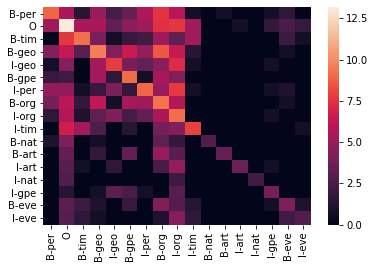

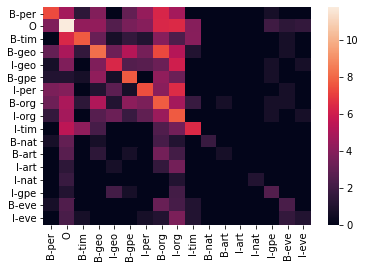

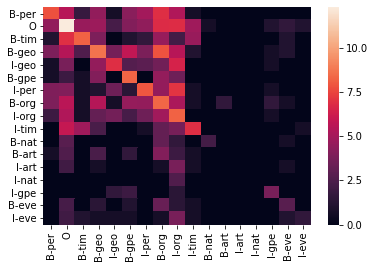

In [96]:
conf_train, conf_val, conf_test= show_confussion_images()

In [97]:
# Evaluate and print number of sentences without error
eval_train = sentences_no_errors_corpus(train_seq.seq_list, pred_train)
eval_val = sentences_no_errors_predictions(Y_val, pred_val)
eval_test = sentences_no_errors_predictions(Y_test, pred_test)

print("SP - Number of sentences Train: %.0f Validation: %.0f Test: %.0f"%(len(pred_train), len(Y_val), len(Y_test)))
print("SP - Number of sentences wihtout error Train: %.0f Validation: %.0f Test: %.0f"%(eval_train, eval_val, eval_test))

SP - Number of sentences Train: 28773 Validation: 7194 Test: 11989
SP - Number of sentences wihtout error Train: 16049 Validation: 3612 Test: 5972


In [98]:
sp.save_model("comparison_extended_features_7")

## Closest word + suffix + capitalized + uppercase + dot + hyphen + numeric + lettersNumbers

In [99]:
feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(train_seq, spelling, closestWord = True,
                                                                  suffix = True, capitalized = True,
                                                                  uppercase = True, Dot = True,
                                                                  Hyphen = True, Numeric = True,
                                                                  LettersNumbers = True, DaysWeek = False)
feature_mapper.build_features() #get the features
#Show the tags
set([x.split(":")[0] for x in feature_mapper.feature_dict.keys()])

{'Dot',
 'Hyphen',
 'LettersNumbers',
 'Numeric',
 'capitalized',
 'closestWord',
 'final_prev_tag',
 'id',
 'init_tag',
 'prev_tag',
 'suffix',
 'uppercase'}

In [100]:
%%time
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, feature_mapper)
num_epochs = 15
sp.fit(feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.927448
Epoch: 1 Accuracy: 0.942971
Epoch: 2 Accuracy: 0.947346
Epoch: 3 Accuracy: 0.950456
Epoch: 4 Accuracy: 0.952367
Epoch: 5 Accuracy: 0.954022
Epoch: 6 Accuracy: 0.955478
Epoch: 7 Accuracy: 0.956820
Epoch: 8 Accuracy: 0.957808
Epoch: 9 Accuracy: 0.958278
Epoch: 10 Accuracy: 0.959013
Epoch: 11 Accuracy: 0.959766
Epoch: 12 Accuracy: 0.960529
Epoch: 13 Accuracy: 0.960445
Epoch: 14 Accuracy: 0.961173
CPU times: user 1h 2min 3s, sys: 1.57 s, total: 1h 2min 4s
Wall time: 1h 2min 1s


In [101]:
pred_val, pred_test, pred_train = get_prediction_results()
eval_train, eval_val, eval_test = get_prediction_acc(pred_val, pred_train, pred_test)
print("SP -  Accuracy Train: %.4f Validation: %.4f Test: %.4f"%(eval_train, eval_val, eval_test))

SP -  Accuracy Train: 0.9579 Validation: 0.9488 Test: 0.9491


In [102]:
for new_seq in sentences_seq_test:
    print(sp.viterbi_decode(new_seq)[0].to_words(train_seq,
                                       only_tag_translation=True))

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
The/O programmers/O from/O Barchelona/B-org might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
Jack/B-per London/B-geo went/O to/O Parris./B-eve 
Jack/B-per London/B-geo went/O to/O Paris./B-eve 
We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O 
We/O never/O though/O Microsof/B-org would/O become/O such/O a/O big/O company./O 
The/O president/O of/O U.S.A./B-org though/O they/O would/O win/O the/O war/O 
The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo though/O they/O could/O win/O the/O war/O 
The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O 
Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-org Arabia./I-org 
Apple/O is/O a/O great/O company./O 
I/O really/O love/O apples/O and/O oranges./O 


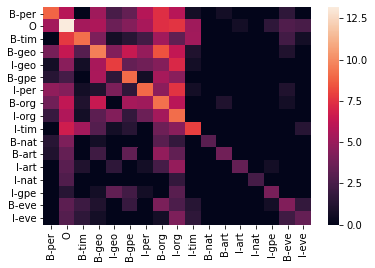

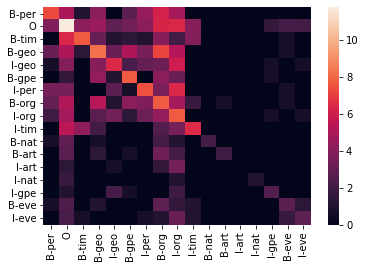

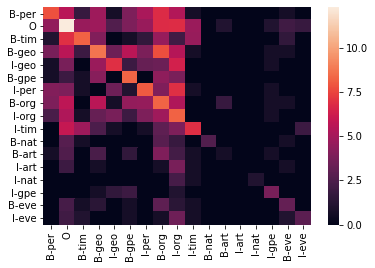

In [103]:
conf_train, conf_val, conf_test= show_confussion_images()

In [104]:
# Evaluate and print number of sentences without error
eval_train = sentences_no_errors_corpus(train_seq.seq_list, pred_train)
eval_val = sentences_no_errors_predictions(Y_val, pred_val)
eval_test = sentences_no_errors_predictions(Y_test, pred_test)

print("SP - Number of sentences Train: %.0f Validation: %.0f Test: %.0f"%(len(pred_train), len(Y_val), len(Y_test)))
print("SP - Number of sentences wihtout error Train: %.0f Validation: %.0f Test: %.0f"%(eval_train, eval_val, eval_test))

SP - Number of sentences Train: 28773 Validation: 7194 Test: 11989
SP - Number of sentences wihtout error Train: 16430 Validation: 3703 Test: 6126


In [105]:
sp.save_model("comparison_extended_features_8")

## Closest word + suffix + capitalized + uppercase + dot + hyphen + numeric + lettersNumbers + daysweek

In [106]:
feature_mapper = skseq.sequences.extended_feature.ExtendedFeatures(train_seq, spelling, closestWord = True,
                                                                  suffix = True, capitalized = True,
                                                                  uppercase = True, Dot = True,
                                                                  Hyphen = True, Numeric = True,
                                                                  LettersNumbers = True, DaysWeek = True)
feature_mapper.build_features() #get the features
#Show the tags
set([x.split(":")[0] for x in feature_mapper.feature_dict.keys()])

{'DaysWeek',
 'Dot',
 'Hyphen',
 'LettersNumbers',
 'Numeric',
 'capitalized',
 'closestWord',
 'final_prev_tag',
 'id',
 'init_tag',
 'prev_tag',
 'suffix',
 'uppercase'}

In [107]:
%%time
sp = spc.StructuredPerceptron(word_to_pos, tag_to_pos, feature_mapper)
num_epochs = 15
sp.fit(feature_mapper.dataset, num_epochs)

Epoch: 0 Accuracy: 0.927741
Epoch: 1 Accuracy: 0.943151
Epoch: 2 Accuracy: 0.947397
Epoch: 3 Accuracy: 0.950626
Epoch: 4 Accuracy: 0.952347
Epoch: 5 Accuracy: 0.954350
Epoch: 6 Accuracy: 0.955672
Epoch: 7 Accuracy: 0.956563
Epoch: 8 Accuracy: 0.957552
Epoch: 9 Accuracy: 0.958423
Epoch: 10 Accuracy: 0.959405
Epoch: 11 Accuracy: 0.959569
Epoch: 12 Accuracy: 0.960677
Epoch: 13 Accuracy: 0.960512
Epoch: 14 Accuracy: 0.961253
CPU times: user 1h 1min 42s, sys: 1.78 s, total: 1h 1min 44s
Wall time: 1h 1min 41s


In [108]:
pred_val, pred_test, pred_train = get_prediction_results()
eval_train, eval_val, eval_test = get_prediction_acc(pred_val, pred_train, pred_test)
print("SP -  Accuracy Train: %.4f Validation: %.4f Test: %.4f"%(eval_train, eval_val, eval_test))

SP -  Accuracy Train: 0.9582 Validation: 0.9487 Test: 0.9495


In [109]:
for new_seq in sentences_seq_test:
    print(sp.viterbi_decode(new_seq)[0].to_words(train_seq,
                                       only_tag_translation=True))

The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
The/O programmers/O from/O Barchelona/B-org might/O write/O a/O sentence/O without/O a/O spell/O checker./O 
Jack/B-per London/B-geo went/O to/O Parris./B-eve 
Jack/B-per London/B-geo went/O to/O Paris./B-eve 
We/O never/O though/O Microsoft/B-org would/O become/O such/O a/O big/O company./O 
We/O never/O though/O Microsof/B-org would/O become/O such/O a/O big/O company./O 
The/O president/O of/O U.S.A./B-org though/O they/O would/O win/O the/O war/O 
The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo though/O they/O could/O win/O the/O war/O 
The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control./O 
Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-per Arabia./I-per 
Apple/O is/O a/O great/O company./O 
I/O really/O love/O apples/O and/O oranges./O 


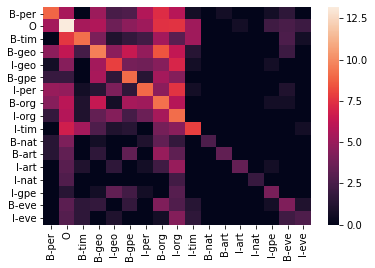

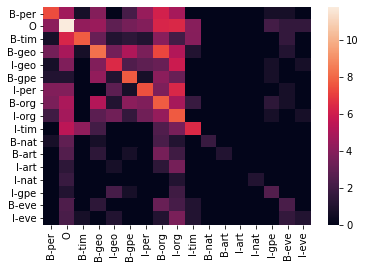

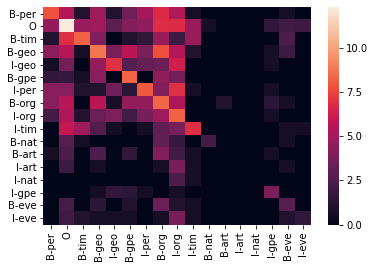

In [110]:
conf_train, conf_val, conf_test= show_confussion_images()

In [111]:
# Evaluate and print number of sentences without error
eval_train = sentences_no_errors_corpus(train_seq.seq_list, pred_train)
eval_val = sentences_no_errors_predictions(Y_val, pred_val)
eval_test = sentences_no_errors_predictions(Y_test, pred_test)

print("SP - Number of sentences Train: %.0f Validation: %.0f Test: %.0f"%(len(pred_train), len(Y_val), len(Y_test)))
print("SP - Number of sentences wihtout error Train: %.0f Validation: %.0f Test: %.0f"%(eval_train, eval_val, eval_test))

SP - Number of sentences Train: 28773 Validation: 7194 Test: 11989
SP - Number of sentences wihtout error Train: 16504 Validation: 3727 Test: 6135


In [112]:
sp.save_model("comparison_extended_features_9")

# Accuracy plots

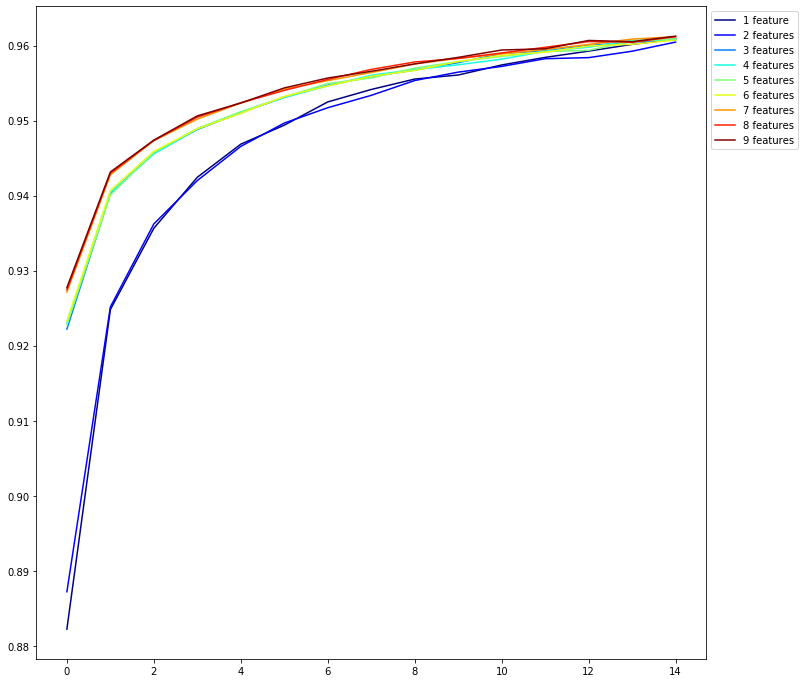

In [116]:
acc1 = [0.882237, 0.924819, 0.935656, 0.942448, 0.946860, 0.949389, 0.952488, 0.954146, 0.955534, 0.956071, 
        0.957412,  0.958421, 0.959256, 0.960157, 0.960857]

acc2= [0.887219, 0.925168, 0.936232, 0.942011, 0.946561, 0.949671, 0.951715, 0.953362, 0.955339, 0.956458, 
       0.957219, 0.958245, 0.958389, 0.959243, 0.960461]

acc3= [0.922210, 0.940324, 0.945706, 0.948811, 0.951070, 0.953092, 0.954714, 0.955855, 0.956731, 0.957720,
        0.958944, 0.959294, 0.960000, 0.960455, 0.960885]

acc4 = [0.923056, 0.940415, 0.945558, 0.948881, 0.951154, 0.953087, 0.954622, 0.956051, 0.956798, 0.957437,
        0.958186, 0.959238, 0.959779, 0.960699, 0.960692]

acc5 = [0.922795, 0.940110, 0.945760, 0.948957, 0.951172, 0.953146, 0.954943, 0.955676, 0.956994, 0.957870,
        0.958547, 0.959197, 0.959359, 0.960617, 0.960887]

acc6 = [0.923299, 0.940679, 0.945905, 0.948906, 0.950959, 0.953229, 0.954615, 0.955911, 0.956676, 0.957876,
        0.958672, 0.959118, 0.959938, 0.960172, 0.960728]

acc7 = [0.927138, 0.942781, 0.947334, 0.950192, 0.952339, 0.954210, 0.955321, 0.956399, 0.957548, 0.958288,
        0.958884, 0.959482, 0.960149, 0.960862, 0.961180]

acc8 = [0.927448, 0.942971, 0.947346, 0.950456, 0.952367, 0.954022, 0.955478, 0.956820, 0.957808, 0.958278,
        0.959013, 0.959766, 0.960529, 0.960445, 0.961173]

acc9 = [0.927741, 0.943151, 0.947397, 0.950626, 0.952347, 0.954350, 0.955672, 0.956563, 0.957552, 0.958423,
        0.959405, 0.959569, 0.960677, 0.960512, 0.961253]

accs = [acc1, acc2, acc3, acc4, acc5, acc6, acc7, acc8, acc9]
labels = ["1 feature", "2 features", "3 features", "4 features", "5 features", "6 features", "7 features", "8 features", "9 features"]

plt.figure(figsize=(12, 12))
colors = cm.jet(np.linspace(0, 1, num=9))
for i in range(9):
    plt.plot(accs[i], color=colors[i])
plt.legend(labels, bbox_to_anchor=(1,1))
plt.show()    

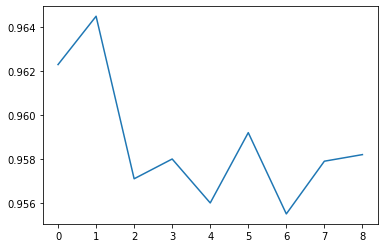

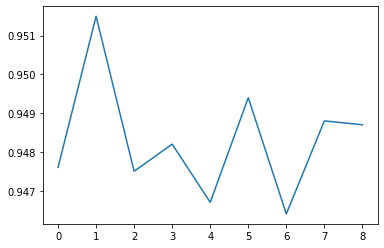

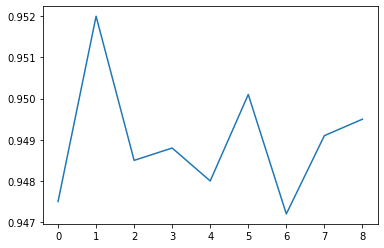

In [121]:
acc_tr = [0.9623 , 0.9645 , 0.9571 , 0.9580 , 0.9560 , 0.9592 , 0.9555 , 0.9579 , 0.9582] 
acc_v = [0.9476, 0.9515, 0.9475, 0.9482, 0.9467, 0.9494, 0.9464, 0.9488, 0.9487]
acc_te = [0.9475,  0.9520,  0.9485,  0.9488,  0.9480,  0.9501,  0.9472,  0.9491,  0.9495]

labels = ["1 feature", "2 features", "3 features", "4 features", "5 features", "6 features", "7 features", "8 features", "9 features"]

plt.plot(acc_tr)
plt.show()
plt.plot(acc_v)
plt.show()
plt.plot(acc_te)
plt.show()